In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from itertools import permutations
from itertools import product
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [67]:
#read all csv files
customer = pd.read_csv("Customer(fix).csv", sep=";")
transaction = pd.read_csv("Transaction(fix).csv", sep=";")
product = pd.read_csv("Product(fix).csv", sep=";")
store = pd.read_csv("Store(fix).csv", sep=";")

In [68]:
print(customer)
print(customer.info())

     CustomerID  Age  Gender Marital Status  Income
0             1   55    Male        Married    5.12
1             2   60    Male        Married    6.23
2             3   32    Male        Married    9.17
3             4   31    Male        Married    4.87
4             5   58    Male        Married    3.57
..          ...  ...     ...            ...     ...
442         443   33    Male        Married    9.28
443         444   53  Female        Married   15.31
444         445   51  Female        Married   14.48
445         446   57  Female        Married    7.81
446         447   54    Male        Married   20.37

[447 rows x 5 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447 entries, 0 to 446
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   CustomerID      447 non-null    int64  
 1   Age             447 non-null    int64  
 2   Gender          447 non-null    object 
 3   Marital Status  44

In [69]:
print(transaction)
print(transaction.info())

     TransactionID  CustomerID        Date ProductID  Price  Qty  TotalAmount  \
0          TR11369         328  2022-01-01        P3   7500    4        30000   
1          TR16356         165  2022-01-01        P9  10000    7        70000   
2           TR1984         183  2022-01-01        P1   8800    4        35200   
3          TR35256         160  2022-01-01        P1   8800    7        61600   
4          TR41231         386  2022-01-01        P9  10000    1        10000   
...            ...         ...         ...       ...    ...  ...          ...   
5015       TR54423         243  2022-12-31       P10  15000    5        75000   
5016        TR5604         271  2022-12-31        P2   3200    4        12800   
5017       TR81224          52  2022-12-31        P7   9400    6        56400   
5018       TR85016          18  2022-12-31        P8  16000    3        48000   
5019       TR85684          55  2022-12-31        P8  16000    1        16000   

      StoreID  
0          

In [70]:
#Changing the data type of the "Date" column to datetime
transaction['Date'] = pd.to_datetime(transaction['Date'])
transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   TransactionID  5020 non-null   object        
 1   CustomerID     5020 non-null   int64         
 2   Date           5020 non-null   datetime64[ns]
 3   ProductID      5020 non-null   object        
 4   Price          5020 non-null   int64         
 5   Qty            5020 non-null   int64         
 6   TotalAmount    5020 non-null   int64         
 7   StoreID        5020 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 313.9+ KB


In [71]:
print(product)
print(product.info())

  ProductID   Product Name  Price
0        P1      Choco Bar   8800
1        P2  Ginger Candy    3200
2        P3       Crackers   7500
3        P4    Potato Chip  12000
4        P5       Thai Tea   4200
5        P6         Cashew  18000
6        P7   Coffee Candy   9400
7        P8            Oat  16000
8        P9        Yoghurt  10000
9       P10   Cheese Stick  15000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ProductID     10 non-null     object
 1   Product Name  10 non-null     object
 2   Price         10 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 368.0+ bytes
None


In [72]:
print(store)
print(store.info())

    StoreID         StoreName    GroupStore           Type   Latitude  \
0         1     Prima Tendean         Prima   Modern Trade  -6,200000   
1         2  Prima Kelapa Dua         Prima   Modern Trade  -6,914864   
2         3        Prima Kota         Prima   Modern Trade  -7,797068   
3         4       Gita Ginara          Gita  General Trade  -6,966667   
4         5           Bonafid          Gita  General Trade  -7,250445   
5         6            Lingga        Lingga   Modern Trade  -5,135399   
6         7       Buana Indah         Buana  General Trade   3,316694   
7         8     Sinar Harapan  Harapan Baru  General Trade   5,548290   
8         9            Lingga        Lingga   Modern Trade  -3,654703   
9        10      Harapan Baru  Harapan Baru  General Trade   3,597031   
10       11     Sinar Harapan      Prestasi  General Trade   0,533505   
11       12    Prestasi Utama      Prestasi  General Trade  -2,990934   
12       13             Buana         Buana  Genera

In [73]:
# Combine all data into a merged new dataframe.
df = pd.merge(transaction,customer,on='CustomerID')
df = pd.merge(df,product,on='ProductID', suffixes=('_Customer','_Product'))
df = pd.merge(df,store,on='StoreID')
df = df.sort_values(by='Date')
df.head()

,TransactionID,CustomerID,Date,ProductID,Price_Customer,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,Price_Product,StoreName,GroupStore,Type,Latitude,Longitude
0,TR11369,328,2022-01-01,P3,7500,4,30000,12,36,Female,Married,10.53,Crackers,7500,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
4814,TR35256,160,2022-01-01,P1,8800,7,61600,4,48,Male,Married,12.57,Choco Bar,8800,Gita Ginara,Gita,General Trade,"-6,966667","110,416664"
337,TR76340,287,2022-01-01,P4,12000,4,48000,12,36,Female,Single,3.70,Potato Chip,12000,Prestasi Utama,Prestasi,General Trade,"-2,990934","104,756554"
3042,TR7596,270,2022-01-01,P7,9400,2,18800,14,49,Male,Married,8.81,Coffee Candy,9400,Priangan,Priangan,Modern Trade,"-5,450000","105,266670"
3288,TR54287,51,2022-01-01,P8,16000,2,32000,2,36,Female,Married,7.95,Oat,16000,Prima Kelapa Dua,Prima,Modern Trade,"-6,914864","107,608238"


In [74]:
df_ts = df.groupby('Date')[['Qty']].sum()
df_ts



,Qty
Date,
2022-01-01,49
2022-01-02,59
2022-01-03,63
2022-01-04,45
2022-01-05,30
...,...
2022-12-27,70
2022-12-28,68
2022-12-29,42


Text(0.5, 1.0, 'Time Series Plot Quantity')

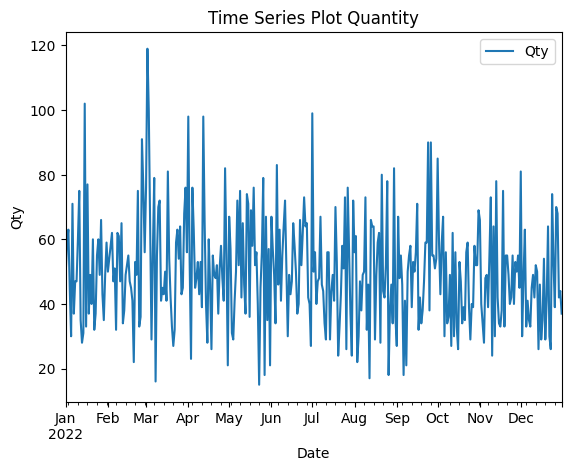

In [75]:
df_ts.plot()
plt.ylabel("Qty")
plt.title("Time Series Plot Quantity")


### ***Checking Data Stationarity***

The hypothesis for testing the stationarity of time series data using the Augmented Dickey-Fuller (ADF) test is as follows:

H0: data is non-stationary

H1: data is stationary

Hypothesis Testing Statistics:
Alpha = 5%

Reject H0 if P-value is less than alpha.

In [76]:
adf_test = adfuller(df_ts['Qty'])
print(f'p-value: {adf_test[1]}')

p-value: 0.0


P-Value < alpha, so we reject H0. Therefore, it can be concluded that the data is stationary, and ARIMA modeling can proceed.






In [77]:
# split into training and testing data by 80/20
train = df_ts['Qty'][:int(0.8*(len(df_ts['Qty'])))]
test = df_ts['Qty'][int(0.8*(len(df_ts['Qty']))):]



### Auto ARIMA

In [78]:
# grid search for p, d, and q
auto_arima_model = pm.auto_arima(
    train,
    seasonal=False,
    stepwise=False,
    suppress_warnings=True,
    trace = True
)
auto_arima_model.summary()

#stepwise=False can provide the flexibility needed, allowing for a more flexible model selection process that can result in higher accuracy models in some cases.

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3158.558, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2971.825, Time=0.15 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2858.751, Time=0.26 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2818.103, Time=0.30 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=2758.656, Time=0.42 sec
 ARIMA(0,0,5)(0,0,0)[0]             : AIC=2742.865, Time=0.51 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2688.721, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2504.937, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2506.794, Time=0.32 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2508.733, Time=0.69 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=2510.161, Time=0.59 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2616.108, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2506.798, Time=0.31 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.37 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.61 sec
 ARIMA(3,0,0)(0,0,0)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  292
Model:               SARIMAX(1, 0, 1)   Log Likelihood               -1249.469
Date:                Sun, 29 Oct 2023   AIC                           2504.937
Time:                        10:55:34   BIC                           2515.968
Sample:                    01-01-2022   HQIC                          2509.356
                         - 10-19-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   3.08e-05   3.25e+04      0.000       1.000       1.000
ma.L1         -0.9898      0.015    -66.556      0.000      -1.019      -0.961
sigma2       298.6887     22.254     13.422      0.000     255.072     342.306
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):                18.30
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.53
Prob(H) (two-sided):                  0.37   Kurtosis:                         3.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

From the provided information, it can be understood that the best-selected model is ARIMA(1,0,1). This refers to the ARIMA order used in the model, specifically having an AR(1) component, differencing component with d=0, and an MA(1) component. There are no seasonal components ([0]).

The white noise assumption entails that the model residuals (remainder after model application) should exhibit white noise properties, such as the absence of significant patterns or correlations. The Ljung-Box test result with a value of 0.16 and a p-value (Prob(Q)) of approximately 0.69 indicates no strong evidence of residual correlation at lag 1, supporting the white noise assumption. This assumption is confirmed.

Heteroskedasticity (H) is 0.83.
The assumption that the variance of residuals (variance of the remainder) is constant. A value of H approaching 1 (in this case, 0.83) suggests that the heteroskedasticity assumption (varying variance) is not met. Ideally, we would want H to approach 0, indicating constant residual variance.

Usually, in ARIMA models, the assumption is that the residual variance (remainder after modeling) is constant, indicating variance stationarity in the data. If your data doesn't meet this assumption and shows heteroskedasticity (varying variance over time), ARIMA may not be suitable for the data. In cases of significant heteroskedasticity, you might consider using a more appropriate model like GARCH (Generalized Autoregressive Conditional Heteroskedasticity) or another model designed to handle variance variability. GARCH models are specifically designed to forecast volatility (variance) in time series data and can be a better choice when data is not variance-stationary.

In [79]:
p, d, q = auto_arima_model.order
model = SARIMAX(train.values, order=(p,d,q))
auto_arima_model_fit = model.fit(disp=False)

In [80]:
# count rsme
predictions = auto_arima_model_fit.predict(start=len(train), end=len(train)+len(test)-1)
rmse = mean_squared_error(test, predictions, squared=False)
rmse

14.153760587024204

### Hyper Parameter Tuning

In [81]:
from itertools import product
# Create lists for p, d, and q
p = range(0, 4)  # 0-3
d = range(0, 4)  # 0-3
q = range(0, 4)  # 0-3
# Use the product function from itertools to create combinations of p, d, and q
pdq = list(product(p, d, q))
print(pdq)


[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 3, 0), (3, 3, 1), (3, 3, 2), (3, 3, 3)]


In [82]:
# Create a list to store AIC scores
aic_scores = []
# Perform manual grid search to find optimal p, d, q
for param in pdq:
    # Fit the ARIMA model
    model = ARIMA(train, order=param)
    model_fit = model.fit()
    # Add AIC score to the list
    aic_scores.append({'param': param, 'aic': model_fit.aic})

# Choose the smallest AIC score
best_aic = min(aic_scores, key=lambda x: x['aic'])
print(best_aic)


{'param': (2, 1, 3), 'aic': 2489.2071952804217}


In [83]:
#Hyperparameter tuning
model_hyper = ARIMA(train, order=best_aic['param'])
model_fit_hyper = model_hyper.fit()



In [84]:
# count rsme
predictions = model_fit_hyper.predict(start=len(train), end=len(train)+len(test)-1)
rmse = mean_squared_error(test, predictions, squared=False)
rmse

14.366700283757966

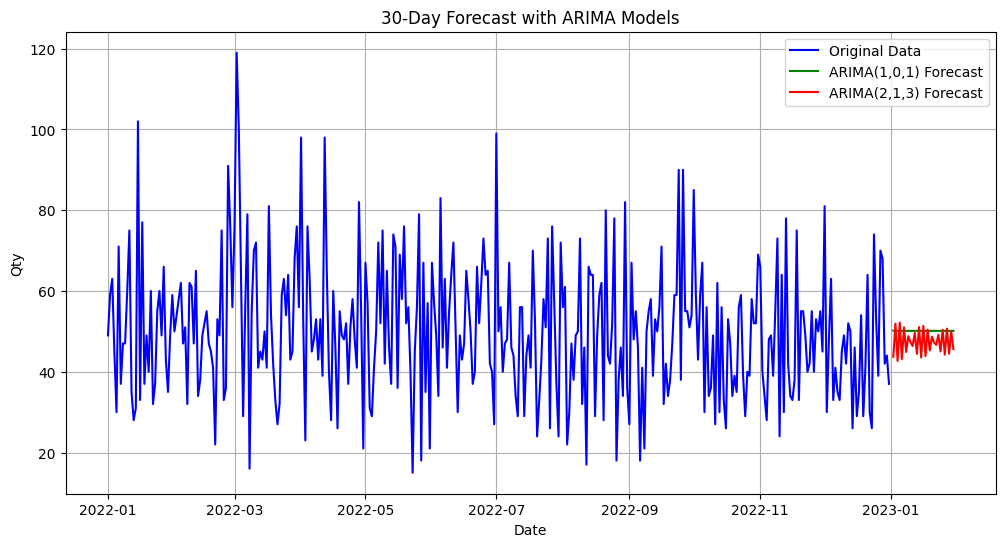

In [85]:
# Data to be used for forecasting
data = df_ts['Qty']

# ARIMA Model (1,0,1)
model_arima_101 = ARIMA(data, order=(1, 0, 1))
model_fit_arima_101 = model_arima_101.fit()

# ARIMA Model (2,1,3)
model_arima_213 = ARIMA(data, order=(2, 1, 3))
model_fit_arima_213 = model_arima_213.fit()

# Perform a 30-day ahead forecast
forecast_steps = 30

# Forecast with ARIMA (1,0,1) model
forecast_arima_101 = model_fit_arima_101.forecast(steps=forecast_steps)

# Forecast with ARIMA (2,1,3) model
forecast_arima_213 = model_fit_arima_213.forecast(steps=forecast_steps)

# Generate date index for the forecast
last_date = data.index[-1]
forecast_index = pd.date_range(start=last_date, periods=forecast_steps + 1, closed='right')[1:]

# Create a DataFrame for the forecast results
forecast_df = pd.DataFrame({'ARIMA(1,0,1)': forecast_arima_101, 'ARIMA(2,1,3)': forecast_arima_213}, index=forecast_index)

# Create a plot of the forecast results
plt.figure(figsize=(12, 6))
plt.plot(data, label='Original Data', color='blue')
plt.plot(forecast_df['ARIMA(1,0,1)'], label='ARIMA(1,0,1) Forecast', color='green')
plt.plot(forecast_df['ARIMA(2,1,3)'], label='ARIMA(2,1,3) Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('30-Day Forecast with ARIMA Models')
plt.legend()
plt.grid(True)
plt.show()


In [88]:
forecast_arima_101.mean()

50.14050880592099

In [86]:
# Select the relevant columns from your DataFrame
product_df = df[['Qty', 'Date', 'Product Name']]

# Group the data by 'Product Name'
df_product = product_df.groupby("Product Name")

# Create a DataFrame to store the forecasts
forecast_product_df = pd.DataFrame({'Date': pd.date_range(start='2023-01-01', periods=90)})

# Define the ARIMA order (1, 0, 1)
p, d, q = 1, 0, 1

# Iterate through each product group
for product_name, group_data in df_product:
    target_var = group_data['Qty']

    # Create and fit the ARIMA model
    model = ARIMA(target_var.values, order=(p, d, q))
    model_fit = model.fit()

    # Generate a 90-day forecast
    forecast = model_fit.forecast(steps=90)

    # Store the forecast in the DataFrame
    forecast_product_df[product_name] = forecast

# Set the 'Date' column as the index
forecast_product_df.set_index('Date', inplace=True)

# Display the first few rows of the forecasted DataFrame
print(forecast_product_df.head())


              Cashew  Cheese Stick  Choco Bar  Coffee Candy  Crackers  \
Date                                                                    
2023-01-01  2.650915      2.874813   6.129868      4.008798  3.527210   
2023-01-02  2.359849      2.904585   6.036642      4.011994  3.507776   
2023-01-03  2.510825      2.925083   6.077858      4.014031  3.518046   
2023-01-04  2.432513      2.939197   6.059636      4.015329  3.512619   
2023-01-05  2.473134      2.948915   6.067692      4.016156  3.515487   

            Ginger Candy        Oat  Potato Chip  Thai Tea   Yoghurt  
Date                                                                  
2023-01-01       4.872697  2.034549     2.829799  3.493101  3.988002  
2023-01-02       4.998183  1.980443     2.811482  3.493583  4.027453  
2023-01-03       4.931332  1.991713     2.804698  3.494045  4.021957  
2023-01-04       4.966946  1.989366     2.802186  3.494487  4.022723  
2023-01-05       4.947973  1.989855     2.801256  3.494911  4.

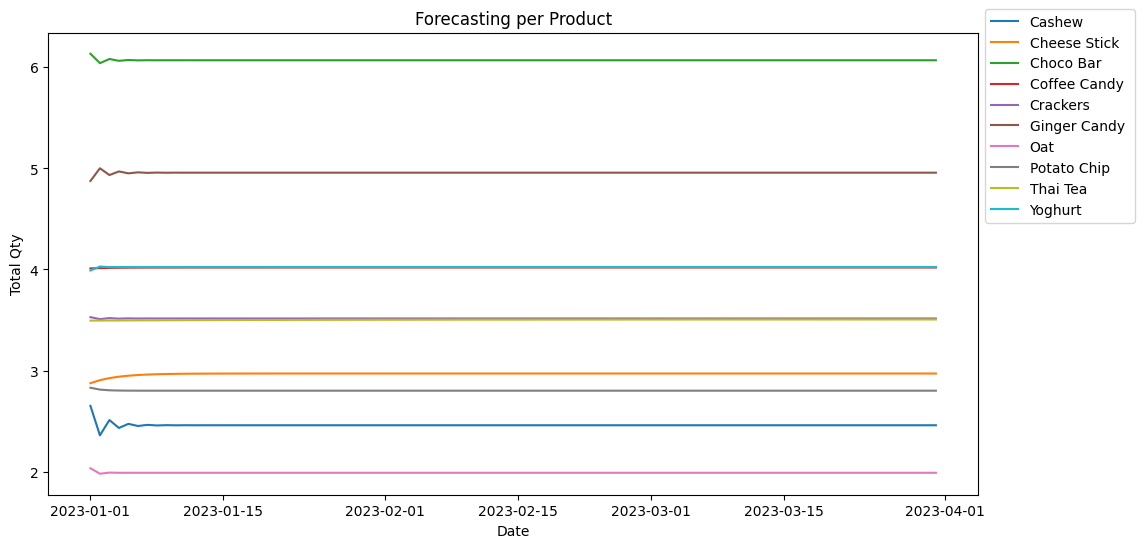

In [90]:
# plot forecast for products
plt.figure(figsize=(12,6))
for i in forecast_product_df.columns:
    plt.plot(forecast_product_df[i], label=i)
plt.legend(loc=6, bbox_to_anchor=(1,.82))
plt.title('Forecasting per Product')
plt.xlabel('Date')
plt.ylabel('Total Qty')
plt.show()